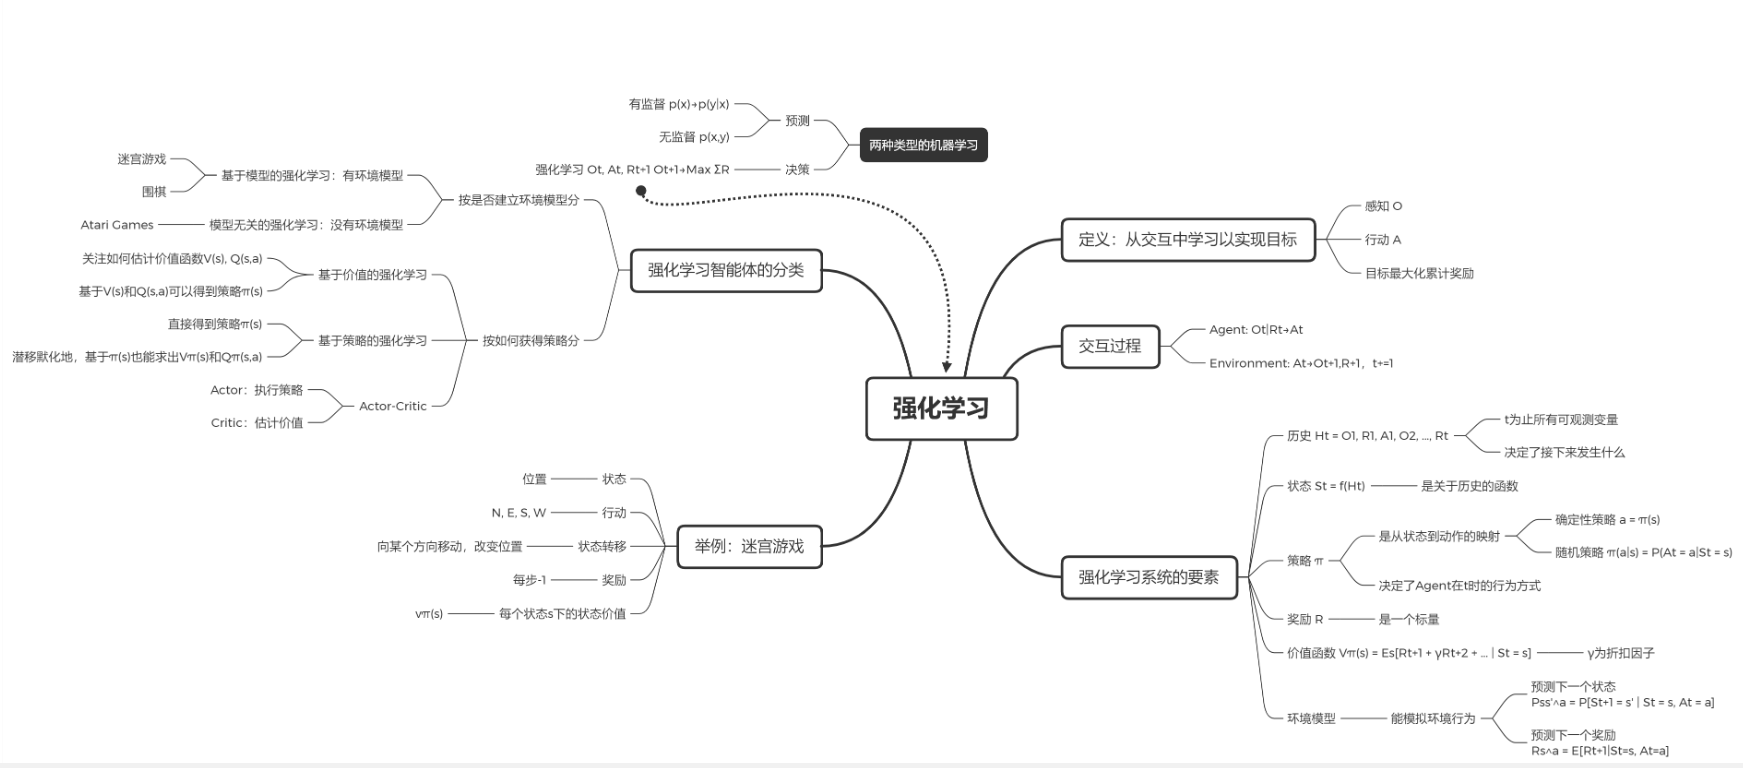

### 1 拉杆数为 10 的多臂老虎机。其中拉动每根拉杆的奖励服从伯努利分布（Bernoulli distribution），即每次拉下拉杆有P的概率获得的奖励为 1，有1-P的概率获得的奖励为 0。奖励为 1 代表获奖，奖励为 0 代表没有获奖。

In [8]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖）。有p=self.probs[k]的概率获奖，1-p的概率不获奖
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


## 2 一个 Solver 基础类来实现MAB的求解方案

In [2]:
# 我们需要实现下列函数功能：根据策略选择动作、根据动作获取奖励、更新期望奖励估值、更新累积懊悔和计数。
# 在下面的 MAB 算法基本框架中，我们将根据策略选择动作、根据动作获取奖励和更新期望奖励估值放在 run_one_step() 函数中，
# 由每个继承 Solver 类的策略具体实现。而更新累积懊悔和计数则直接放在主循环 run() 中。



class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数,shape=(1,K)
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k) # 记录每一步选择的动作
            self.update_regret(k)  # 更新懊悔值
            
            

# 3 .1 ϵ-贪心算法

epsilon-贪婪算法的累积懊悔为： 25.526630933945313 选择每个拉杆的次数为： [6.000e+00 4.943e+03 6.000e+00 3.000e+00 7.000e+00 7.000e+00 5.000e+00
 9.000e+00 8.000e+00 6.000e+00]


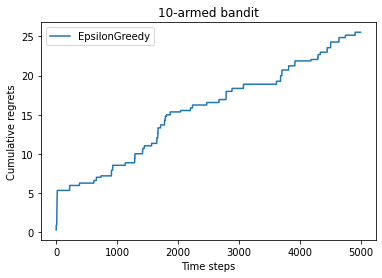

In [41]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)  # shape=(1,K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r -self.estimates[k])  # 更新本次选择动作的期望奖励的估值
        return k
    
    
# 画图
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret,'选择每个拉杆的次数为：', epsilon_greedy_solver.counts)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

# 3.2 尝试不同的参数{10e-4,0.01,0.1,0.25,,0.5}

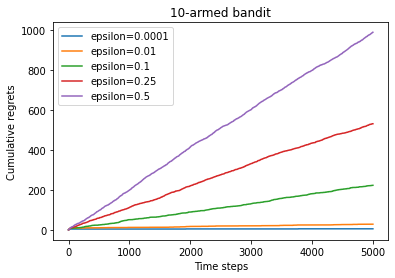

In [25]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

# 4 ϵ随时间衰减的ϵ-贪婪算法

epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183 选择每个拉杆的次数为： [5.000e+00 4.975e+03 2.000e+00 3.000e+00 1.000e+00 3.000e+00 1.000e+00
 2.000e+00 5.000e+00 3.000e+00]


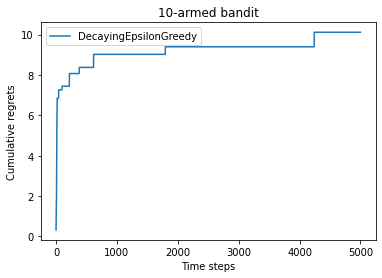

In [39]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret,'选择每个拉杆的次数为：',decaying_epsilon_greedy_solver.counts)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

# 5 上置信界算法

上置信界算法的累积懊悔为： 70.45281214197854 选择每个拉杆的次数为： [  33. 4773.    7.    7.   14.   10.   14.   10.   21.  111.]


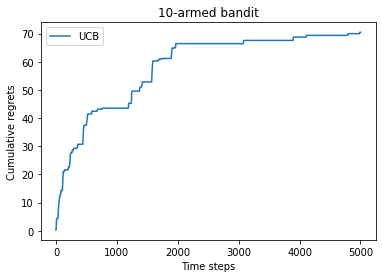

In [42]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k


np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret,'选择每个拉杆的次数为：',UCB_solver.counts)
plot_results([UCB_solver], ["UCB"])

In [33]:
,bandit_10_arm.probs

(array([  33., 4773.,    7.,    7.,   14.,   10.,   14.,   10.,   21.,
         111.]),
 array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
        1.46755891e-01, 9.23385948e-02, 1.86260211e-01, 3.45560727e-01,
        3.96767474e-01, 5.38816734e-01]))

# 6 汤普森采样-Thompson sampling算法

汤普森采样算法的累积懊悔为： 57.19161964443925 选择每个拉杆的次数为： [  26. 4810.    6.    6.   11.    8.    6.   15.   14.   98.]


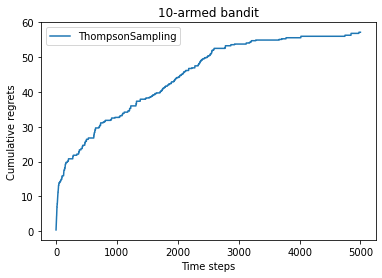

In [43]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
# 先假设每个动作服从一个(1,1)的beta分布，然后对每个动作采样奖励，然后选取最大奖励最大的动作，然后更新beta参数，最后逐渐清楚每个动作的具体分布
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本。
        

        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k


np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret,'选择每个拉杆的次数为：',thompson_sampling_solver.counts)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

In [48]:
samples = np.random.beta(thompson_sampling_solver._a, thompson_sampling_solver._b)
print(samples)

[0.52364974 0.71913547 0.03083506 0.01397005 0.34271048 0.26215002
 0.24557905 0.32389714 0.26989034 0.57942772]
